In [1]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util

from collections import defaultdict
import torch
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt

/usr/local/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
vrf_data_path = "../TOY_DATA/TOY_vrf_data2024.xlsx"
seva_data_path = "../TOY_DATA/TOY_seva_modified20apr.xlsx"

vrf_df = pd.read_excel(vrf_data_path)
candidate_info_df = pd.read_excel(seva_data_path)

In [4]:
vrf_jobs_df = vrf_df['/']
skills_jobs_df_arr = [
        candidate_info_df['Work Experience/Designation'].dropna(),
        candidate_info_df['Any Additional Skills'].dropna(),
        candidate_info_df['Computer Skills'].dropna(),
        candidate_info_df['Skills'].dropna(),
        candidate_info_df['Skills.1'].dropna(),
        vrf_jobs_df.dropna()
        ]

stacked_skills_and_jobs = pd.concat(skills_jobs_df_arr, axis=0).reset_index(drop=True)[:100]

In [5]:
# Create Skills and Jobs Embeddings
model = SentenceTransformer('sentence-transformers/all-roberta-large-v1', device='cpu')
print('EMBEDDING SKILLS...')
embeddings = model.encode(stacked_skills_and_jobs, convert_to_tensor=True, show_progress_bar=True, device='cpu')
embeddings_np = embeddings.numpy()

/usr/local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


EMBEDDING SKILLS...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

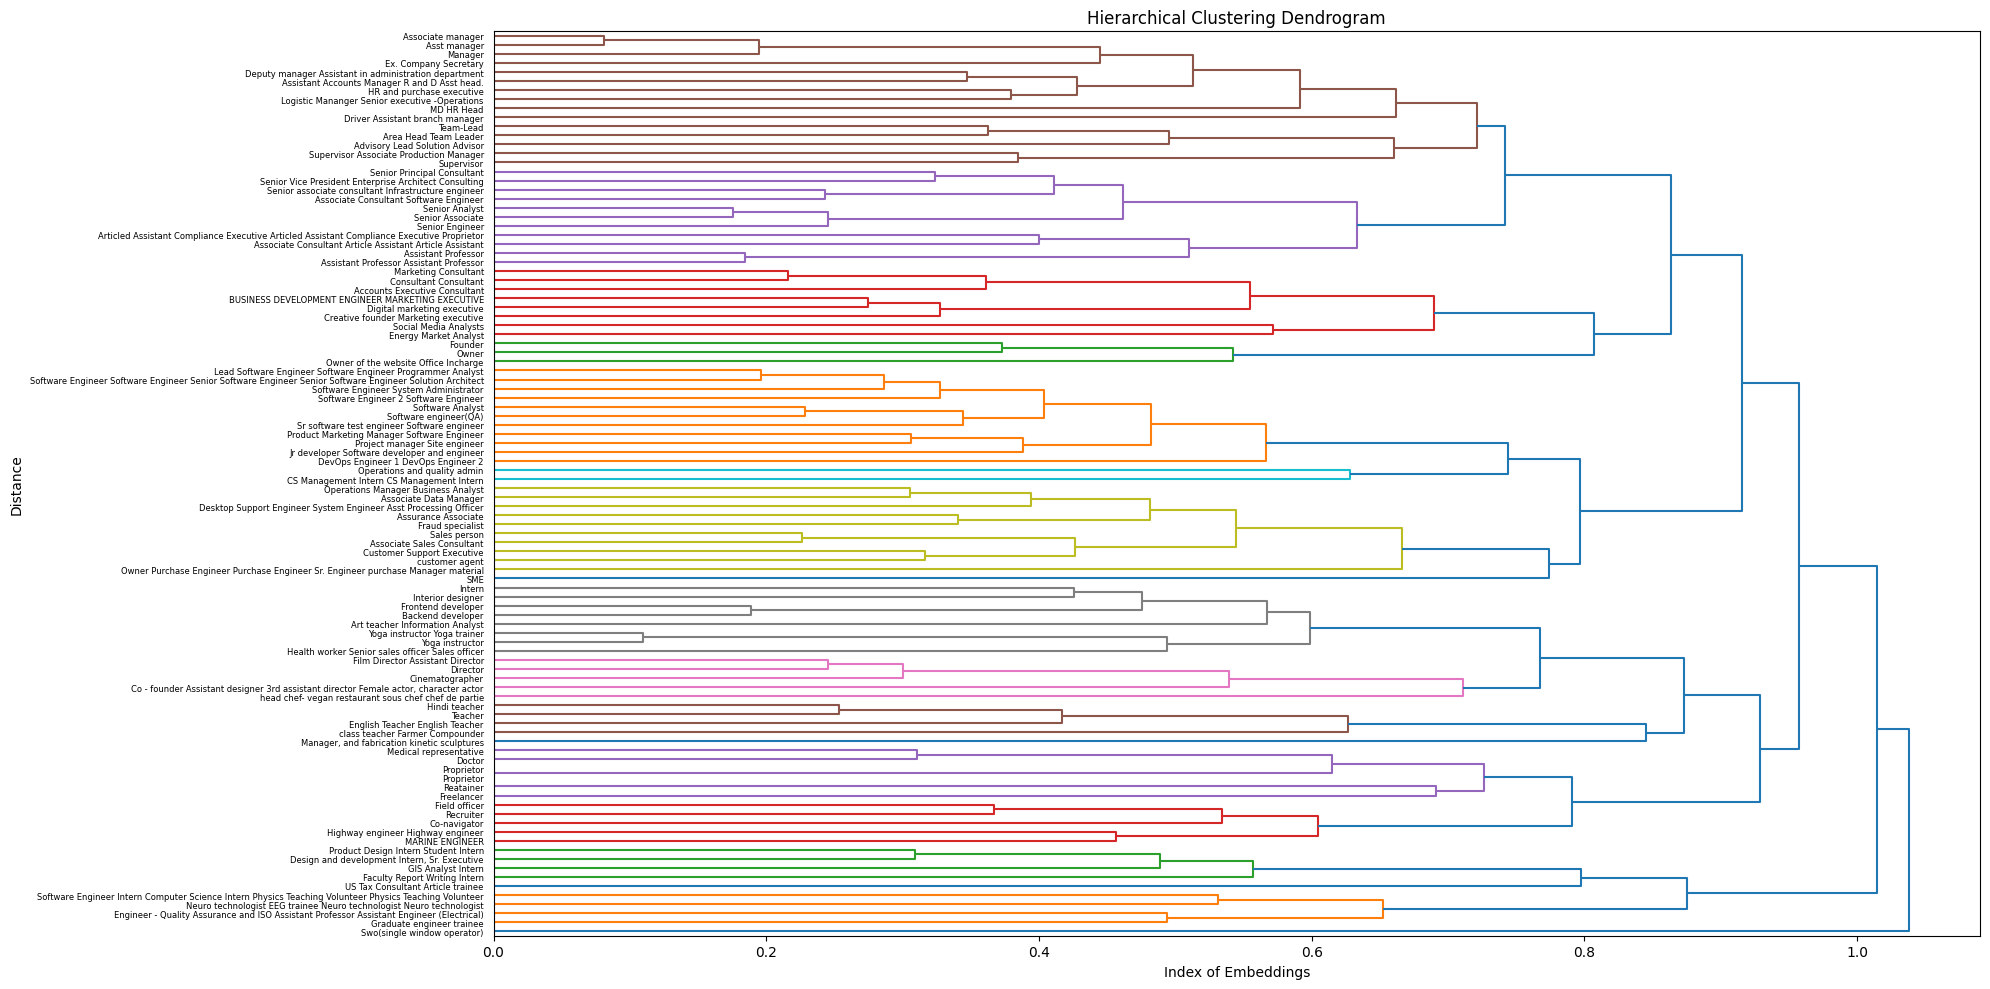

In [7]:
# Perform Hierarchical Clustering
Z = sch.linkage(
    embeddings_np,
    method='complete',
    metric='cosine',
    optimal_ordering=True) # set to false when large scale (slows down computation)

# Step 4: Plot the dendrogram to visualize the hierarchy tree
plt.figure(figsize=(20,10))
sch.dendrogram(Z,labels=stacked_skills_and_jobs.values,  leaf_rotation=0, count_sort=True, distance_sort=True, orientation='right', leaf_font_size=6)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Index of Embeddings")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig('dendrogram.png', format='png', dpi=300)
plt.show()

In [8]:
# Step 5: Cut the dendrogram to get clusters K levels up from the leaf nodes
K = 3  # Example: Cut 3 levels up from the leaf nodes
# cluster_labels = sch.cut_tree(Z, height=3, n_clusters=None).flatten()
cluster_labels = sch.fcluster(Z, t=.7, criterion='distance')


# Step 6: Group the string values from the pandas Series by their cluster labels
grouped_strings = defaultdict(list)
for i, label in enumerate(cluster_labels):
    grouped_strings[label].append(stacked_skills_and_jobs[i])  # Group string names by cluster label

# Output the grouped clusters with string values
for label, group in grouped_strings.items():
    print(f"Cluster {label}: {group}")


Cluster 13: ['Logistic Mananger Senior executive -Operations', 'MD HR Head', 'Driver Assistant branch manager', 'Ex. Company Secretary', 'Assistant Accounts Manager R and D Asst head.', 'Deputy manager Assistant in administration department', 'Associate manager', 'Manager', 'HR and purchase executive', 'Asst manager']
Cluster 15: ['SME']
Cluster 16: ['Project manager Site engineer', 'Product Marketing Manager Software Engineer', 'Sr software test engineer Software engineer', 'Software engineer(QA)', 'Software Engineer Software Engineer Senior Software Engineer Senior Software Engineer Solution Architect', 'Software Engineer 2 Software Engineer', 'DevOps Engineer 1 DevOps Engineer 2', 'Software Engineer System Administrator', 'Lead Software Engineer Software Engineer Programmer Analyst', 'Software Analyst', 'Jr developer Software developer and engineer']
Cluster 10: ['Energy Market Analyst', 'BUSINESS DEVELOPMENT ENGINEER MARKETING EXECUTIVE', 'Consultant Consultant', 'Marketing Consult

torch.Size([2359, 1024])